`Content` <p>
[Part 0. Background](#Part-0.-Background) <p>
[Part 1.Data loading and overview](#Part-1.Data-loading-and-overview) <p>
[Part 2. Data cleaning and transforming](#Part-2.-Data-cleaning-and-transforming) <p>
[Conclusion](#Conclusion) <p>
[Part 3. Exploratory data analysis](#Part-3.-Exploratory-data-analysis) <p>
[Conclusion](#Conclusion) <p>
[Part 4. Regional differences](#Part-4.-Regional-differences) <p>
[Conclusion](#Conclusion) <p>
[Part 5. Hypothesis testing](#Part-5.-Hypothesis-testing) <p>
[Overall conclusion](#Overall-conclusion)

# Part 0. Background

We work for the online store Ice, which sells video games all over the world. User and expert reviews, genres, platforms (e.g. Xbox or PlayStation), and historical data on game sales up to 2016 are available from open sources. 

We need to identify patterns that determine whether a game succeeds or not. This will allow to spot potential big winners and plan advertising campaigns for 2017 year.

# Part 1.Data loading and overview 

In [1]:
import pandas as pd
import numpy as np
import nltk
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats as st
import warnings
warnings.filterwarnings("ignore")
plt.style.use('seaborn-whitegrid') 
sns.set_style('whitegrid')

In [2]:
games = pd.read_csv('/datasets/games.csv')
games_original = pd.read_csv('/datasets/games.csv')

In [3]:
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
games.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [6]:
games.isnull().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

<b> First thoughts: </b> We have pretty messy data, a lot of missing values that can't be restored since each game is rather unique and can't be attributed to group, which values we can use. 

# Part 2. Data cleaning and transforming

In [7]:
games.columns = games.columns.str.lower()

In [8]:
games = games.dropna(subset=['name', 'genre'])

### Release year

<i>Small attempt to restore year of release for some games, based on assumption that year that contains in name of the game 
is the year when game was published.  </i>

In [9]:
def finding_number(row):
    name = row['name']
    text = nltk.word_tokenize(name)
    for element in text:
        if element.isdigit() and len(element) == 4:
            return element
        else:
            continue
    return np.nan

In [10]:
games['new_year'] = games.apply(finding_number, axis=1) 

In [11]:
games.loc[games['year_of_release'].isnull(), 'year_of_release'] = games['new_year']

In [12]:
games = games.drop(columns='new_year')

Since there is no way to predict year of release for rest of the games, we will fill them with 0 in order to keep data for other purposes

In [13]:
games['year_of_release'] = games['year_of_release'].fillna(0)
games['year_of_release'] = games['year_of_release'].astype(int)
#games['year_of_release'] = pd.to_datetime(games['year_of_release'], format="%Y").dt.year()

### Rating

In [14]:
games['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

In [15]:
games['rating'] = games['rating'].fillna('unknown')

Since there is no efficient way, how we can predict games rating we going to fill in missing values with "Unknown" category

In [16]:
games['rating'].value_counts()

unknown    6764
E          3990
T          2961
M          1563
E10+       1420
EC            8
K-A           3
RP            3
AO            1
Name: rating, dtype: int64

### Total sales

In order to fill missing values in user score and critic score, we need to calculate total sales first

In [17]:
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [18]:
games['total_sales'] = games[['na_sales', 'eu_sales','jp_sales', 'other_sales']].sum(axis=1)

In [19]:
games['total_sales'].describe()

count    16713.000000
mean         0.533315
std          1.548282
min          0.000000
25%          0.060000
50%          0.170000
75%          0.470000
max         82.540000
Name: total_sales, dtype: float64

Text(0, 0.5, 'Amount')

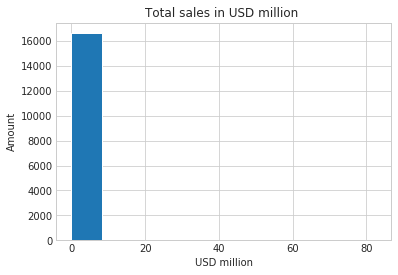

In [20]:
games['total_sales'].hist()
plt.title('Total sales in USD million ')
plt.xlabel('USD million')
plt.ylabel('Amount')

Text(0, 0.5, 'USD million')

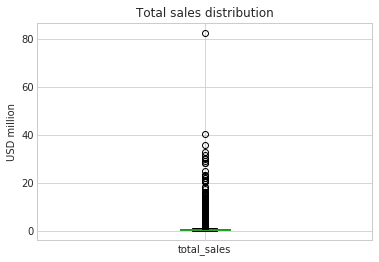

In [21]:
games['total_sales'].plot(kind='box')
plt.title('Total sales distribution')
plt.ylabel('USD million')

In [22]:
games[games['total_sales'] == games['total_sales'].max()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54


We can see, that there are some outliers in term of total sales, so-called 'bestsellers', that significantly outperform everage sales

### User score & Critic score

In [23]:
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [24]:
games[games['user_score'] == 'tbd'].groupby('year_of_release').agg(['count','mean'])

na_sales           eu_sales           jp_sales            \
                   count      mean    count      mean    count      mean   
year_of_release                                                            
0                     46  0.153478       46  0.034130       46  0.000000   
1997                   1  0.030000        1  0.020000        1  0.000000   
1999                   8  0.406250        8  0.110000        8  0.000000   
2000                  43  0.170000       43  0.119767       43  0.007442   
2001                  82  0.147195       82  0.079390       82  0.003415   
2002                 192  0.088385      192  0.037031      192  0.001302   
2003                  96  0.104167       96  0.043542       96  0.000000   
2004                 107  0.139533      107  0.055888      107  0.004299   
2005                 121  0.106777      121  0.039752      121  0.001488   
2006                 124  0.082016      124  0.020806      124  0.011210   
2007                 192  0.152292      192  0.046302      192  0.004740   
2008                 327  0.143517      327  0.046789      327  0.001682   
2009                 405  0.138198      405  0.034370      405  0.001136   
2010                 331  0.149728      331  0.043353      331  0.002538   
2011                 217  0.114839      217  0.040783      217  0.000599   
2012                  24  0.035417       24  0.042917       24  0.010000   
2013                  15  0.024667       15  0.056000       15  0.000667   
2014                  21  0.065238       21  0.067143       21  0.007143   
2015                  38  0.024737       38  0.033158       38  0.010789   
2016                  34  0.020294       34  0.025000       34  0.000882   

                other_sales           critic_score            total_sales  \
                      count      mean        count       mean       count   
year_of_release                                                             
0                        46  0.013261           24  59.083333          46   
1997                      1  0.000000            1  76.000000           1   
1999                      8  0.018750            6  62.000000           8   
2000                     43  0.026512           40  62.075000          43   
2001                     82  0.015000           69  66.304348          82   
2002                    192  0.005833          172  64.337209         192   
2003                     96  0.007500           85  62.000000          96   
2004                    107  0.007570           81  60.222222         107   
2005                    121  0.008926           90  60.477778         121   
2006                    124  0.008871           90  60.700000         124   
2007                    192  0.020521          102  59.019608         192   
2008                    327  0.024312          117  59.264957         327   
2009                    405  0.020420           94  56.553191         405   
2010                    331  0.017885           67  56.955224         331   
2011                    217  0.015853           32  57.406250         217   
2012                     24  0.008333            0        NaN          24   
2013                     15  0.006667            1  38.000000          15   
2014                     21  0.013333            4  54.750000          21   
2015                     38  0.006053            2  57.500000          38   
2016                     34  0.004706            5  70.200000          34   

                           
                     mean  
year_of_release            
0                0.200870  
1997             0.050000  
1999             0.535000  
2000             0.323721  
2001             0.245000  
2002             0.132552  
2003             0.155208  
2004             0.207290  
2005             0.156942  
2006             0.122903  
2007             0.223854  
2008             0.216300  
2009             0.194123  
2010             0.213505  
2011             0.

It seems that games that have 'TBD' as a user score, didn't get enought users reviews to calculate a score. Also it seems that theese games have rather low sales.

In [25]:
games.loc[games['user_score'] == 'tbd', 'user_score'] = 0

In [26]:
games['user_score'] = games['user_score'].astype(float)
games['critic_score'] = games['critic_score'].astype(float)

In [27]:
games.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
count,16713.000000,16713.000000,16713.000000,16713.000000,16713.000000,8137.000000,10014.000000,16713.000000
mean,1976.231676,0.263302,0.145045,0.077625,0.047343,68.967679,5.400350,0.533315
std,244.594319,0.813565,0.503359,0.308871,0.186742,13.938165,3.319671,1.548282
min,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000,2.400000,0.060000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000,6.900000,0.170000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000,8.000000,0.470000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000,9.700000,82.540000


## Conclusion

In order to clean and organize our data we did several steps:
- Droped mising values from Name and Genre columns, since their number is small and there is no sufficient way to restore it
- Restored some missing values in year of release column, based on assumption that name of the game sometimes can include the year when game was published, like Fifa 2015 for example.
- Calculated total sales as summ of sales in all regions

# Part 3. Exploratory data analysis

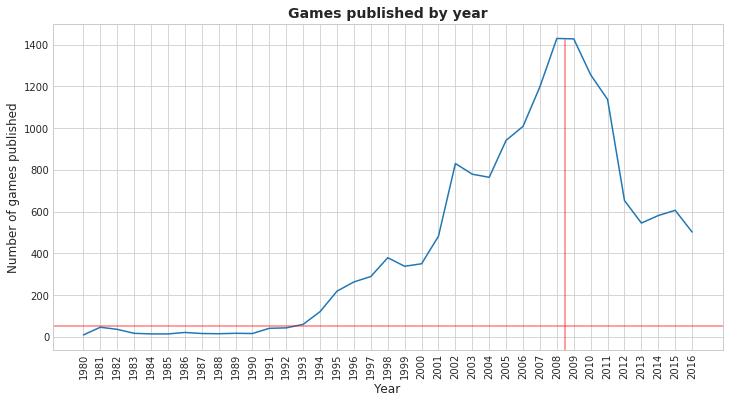

In [28]:
x = games['year_of_release'][games['year_of_release'] != 0].value_counts().index
y = games['year_of_release'][games['year_of_release'] != 0].value_counts().values
plt.subplots(figsize = (12,6))
fig = sns.lineplot(x=x, y=y)
fig.set_xticks(x)
fig.set_xticklabels(x, rotation=90)
fig.set_title('Games published by year', weight='bold', fontsize='14')
fig.set_xlabel('Year', fontsize='12')
fig.set_ylabel('Number of games published', fontsize='12')
plt.axvline(x=2008.5,ymax = 0.95, color = 'red', alpha=0.5)
plt.axhline(y=50, color='red', alpha=0.5)

Based on graph, we can conclude that 2008-2009 were most succsessful years in terms of amount of publised games, and after that this number started to drop. Data for period before 1992 should be considered carefuly, due to low amount of observations

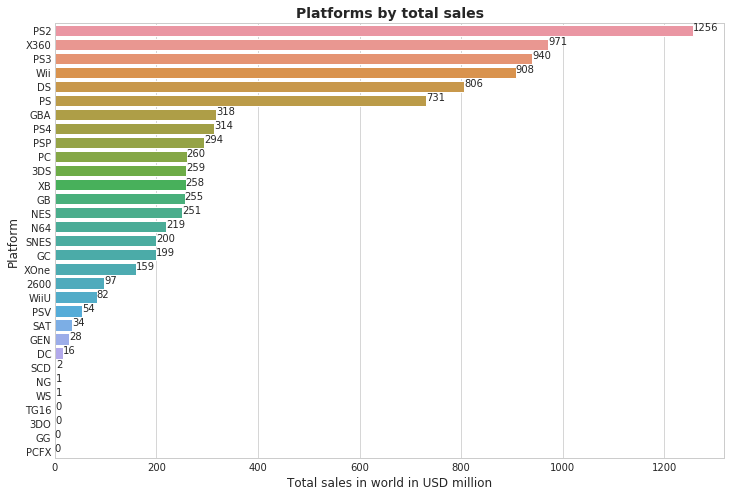

In [31]:
platform_by_sales_slice = games.groupby(['platform']).agg('sum').reset_index().sort_values(by='total_sales', ascending=False)
#fig = px.scatter(platform_by_sales_slice, y='platform', x='total_sales', title='Platforms distribution by total sales',labels={"total_sales":"Total sales in world in USD million"} )
#fig.show()
plt.figure(figsize = (12,8))
fig = sns.barplot(x='total_sales',y='platform', data=platform_by_sales_slice)
fig.set_title('Platforms by total sales', weight='bold', fontsize='14')
fig.set_xlabel('Total sales in world in USD million', fontsize='12')
fig.set_ylabel('Platform', fontsize='12')
for index, value in enumerate(platform_by_sales_slice['total_sales']):
    plt.text(value, index, str(round(value)))

PS2 is a leader in terms of total sales of games, outperforming other platforms. X360 and PS3 follows. PC, surprisingly, only in the average with other platforms. 
For further analysis we will take top 6 platform since, their sales significantly higher than others.

In [32]:
slice_for_z_score = games[['platform', 'total_sales']].groupby('platform').sum().sort_values(by='total_sales').reset_index()
slice_for_z_score['z_score'] = (slice_for_z_score['total_sales'] - slice_for_z_score['total_sales'].mean())/slice_for_z_score['total_sales'].std()
slice_for_z_score['color'] = ['red' if x<0 else 'blue' for x in slice_for_z_score['z_score']]

Text(0, 0.5, 'Platform')

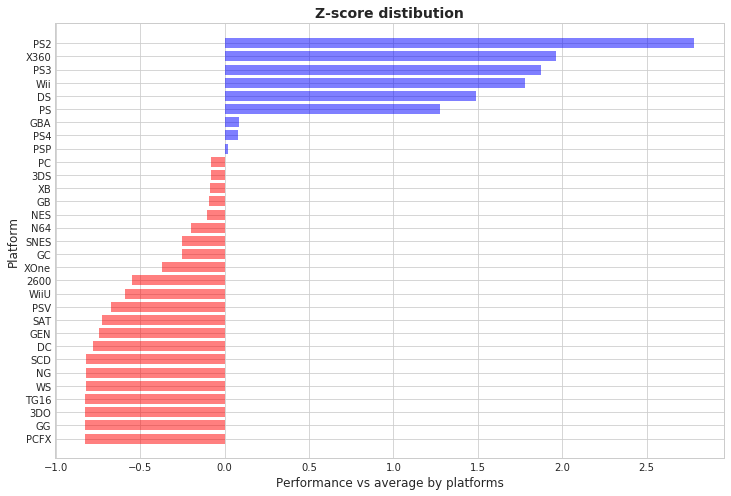

In [33]:
plt.figure(figsize = (12,8))
plt.hlines(y=slice_for_z_score['platform'], xmin=0, xmax=slice_for_z_score['z_score'], color = slice_for_z_score['color'], alpha=0.5, linewidth=10) 
plt.title('Z-score distibution', weight='bold', fontsize='14')
plt.xlabel('Performance vs average by platforms', fontsize='12')
plt.ylabel('Platform', fontsize='12')

Z-score shows how parameter differs from the mean of sample, in our case it shows pretty much the same results - we have 6 leaders in terms of total sales. Its more evident on z-score that PS4, PSP and GBA are also performing slightly better than platforms on average.

Text(0.5, 1.0, 'Leading platforms total sales by year')

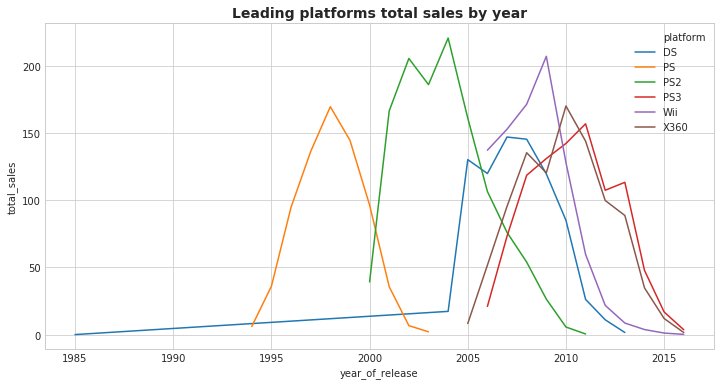

In [34]:
top_platforms = platform_by_sales_slice['platform'].head(6)
platform_slice = games[games['year_of_release'] != 0][['platform','year_of_release','total_sales']].groupby(['platform','year_of_release']).agg('sum').reset_index()
platform_slice = platform_slice[platform_slice['platform'].isin(top_platforms)]
plt.figure(figsize = (12,6))
fig = sns.lineplot(x=platform_slice['year_of_release'], y=platform_slice['total_sales'], hue=platform_slice['platform'])
fig.set_title('Leading platforms total sales by year', weight='bold', fontsize='14')

It seems that for each platform it took about 4 year to reach the peack of their sales and then number of sales starting to go down. Only DS platform showed different trend - it seems that it got popular only after quite some time.

In [35]:
platform_slice_for_profit = games[games['year_of_release'] >= 2000][['platform','year_of_release','total_sales']].groupby(['platform','year_of_release']).agg('sum').reset_index()
pivot_profit = pd.pivot_table(platform_slice_for_profit, index='year_of_release', columns='platform',values='total_sales', aggfunc=sum, fill_value=0)
profit_dinamics = pivot_profit - pivot_profit.shift(+1)
#profit_dinamics.plot(kind='line')

Text(0.5, 1, 'Changes in total sales by platform by year')

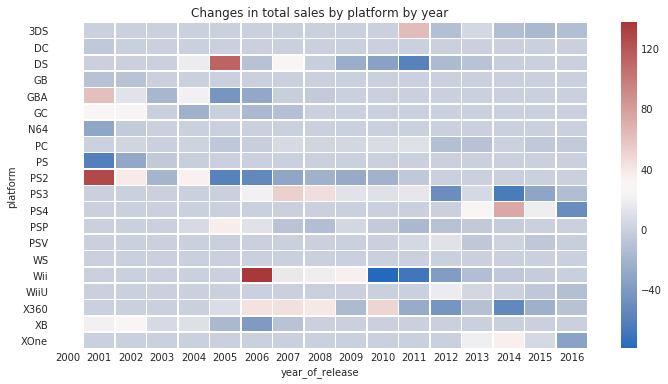

In [36]:
plt.figure(figsize = (12,6))
fig = sns.heatmap(profit_dinamics.T, linewidths=.5, cmap='vlag')
fig.set_title('Changes in total sales by platform by year')

Text(0.5, 0.98, 'Dynamics in total sales by platform by year')

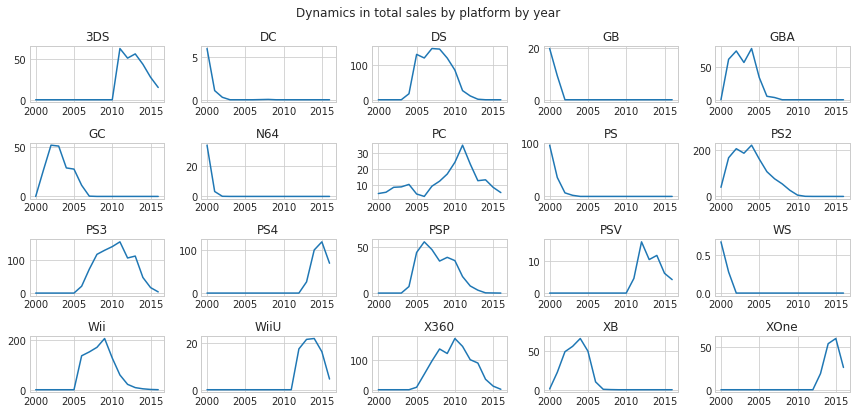

In [37]:
#same data different graph, for me this one is more readable, but i guess its a quiestion of expirience and prefferences
platforms = profit_dinamics.T.index
f, axes = plt.subplots(4, 5, figsize = (12,6))
coordinate_x = 0
coordinate_y = 0
for index in platforms:
    fig = sns.lineplot(data=pivot_profit.T.loc[index], ax = axes[coordinate_x,coordinate_y])
    fig.set_title(index)
    if coordinate_y < 4:
        coordinate_y += 1
    else:
        coordinate_x +=1
        coordinate_y = 0
f.tight_layout(rect=[0, 0.03, 1, 0.95])
f.suptitle('Dynamics in total sales by platform by year')

Based on graphs about changes in total sales we can conclude that:
- On average, it takes about 10 years for platform to appear, reach its peak and then dissapear
- Last several years weren't succsesfull for plafroms in general it could be effect of global economic crysis or it means that its time for new platform to appear and take the market share. Among others we can highlite PS4 and XOne as most promissing ones, that, potentially, could bring some profit in 2017. 

Text(0.5, 1.0, 'Platforms by total sales. Distribution analysis')

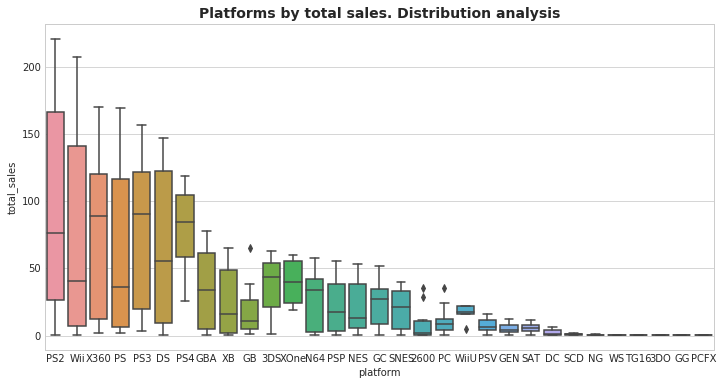

In [38]:
plt.figure(figsize = (12,6))
platform_by_sales = games.groupby(['platform','year_of_release'])['total_sales'].agg('sum').reset_index().sort_values(by='total_sales', ascending=False)
fig = sns.boxplot(data=platform_by_sales, y='total_sales', x='platform')
fig.set_title('Platforms by total sales. Distribution analysis', weight='bold', fontsize='14')

On boxplot graph we can see that, there are significant differences in total sales between platforms. Average sales also varies from platform to platform. This also could be effect of small amount of observations for some platforms
We also need to point out that our consumption about PS4 being a most promising platform is confimed here, since its have quite high average sales and lowest point is quite far away from 0, which means that its never had 0 sales 

In [39]:
def games_scatter(name): 
    df = games[['total_sales','user_score','critic_score']][games['platform'] == name]
    print(name, df.corr())
    plt.figure(figsize = (12,6))
    plt.suptitle('User score impact on total sales. Platform: ')
    fig_1 = sns.scatterplot(data=df, x='user_score', y='total_sales')
    fig_1.set_title(name)
    plt.figure(figsize = (12,6))
    plt.suptitle('Critic score impact on total sales. Platform: ')
    fig_2 = sns.scatterplot(data=df, x='critic_score', y='total_sales')
    fig_2.set_title(name)
    return df.corr() , fig_1, fig_2

PS4               total_sales  user_score  critic_score
total_sales      1.000000    0.023279      0.406568
user_score       0.023279    1.000000      0.520752
critic_score     0.406568    0.520752      1.000000


(              total_sales  user_score  critic_score
 total_sales      1.000000    0.023279      0.406568
 user_score       0.023279    1.000000      0.520752
 critic_score     0.406568    0.520752      1.000000,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0e25859a90>)

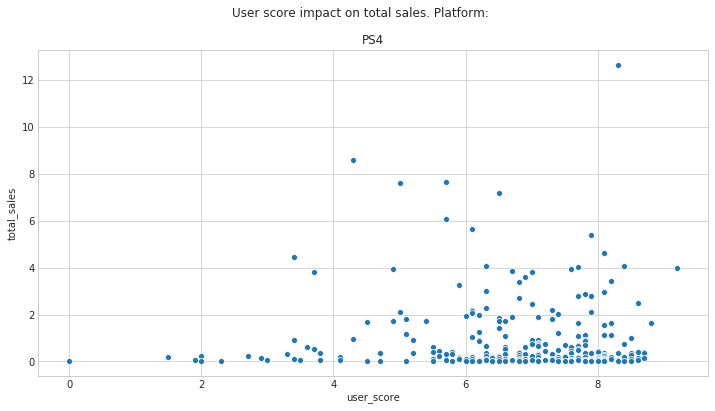

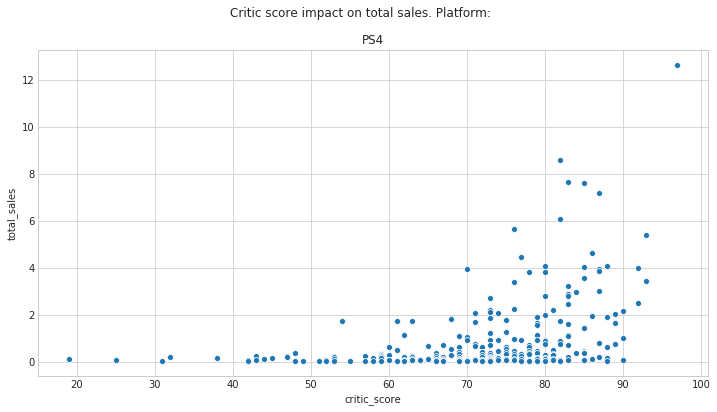

In [40]:
games_scatter('PS4')

By analysing impact of critic score and user score on total sale for PS4 platform we can conclude that:
- It seems that total sales almost are not affected by user score, because we can see that there are quite a few games with rather low user score(5-6), while total sales of them are quite high(6-8 million dollars)
- Critic score have impact on total sales, but rather low - games with higher critic score tend to have higher total sales<p>
    Now we can check if same trends applies for other platforms

In [41]:
top_platforms_slice = games[games['year_of_release'] == 2015].groupby(['year_of_release','platform'])['total_sales'].sum().reset_index().sort_values('total_sales', ascending=False)
top_platforms_list = top_platforms_slice['platform'].head(6)

XOne               total_sales  user_score  critic_score
total_sales      1.000000    0.074486      0.416998
user_score       0.074486    1.000000      0.465368
critic_score     0.416998    0.465368      1.000000
3DS               total_sales  user_score  critic_score
total_sales      1.000000    0.258550      0.349401
user_score       0.258550    1.000000      0.632637
critic_score     0.349401    0.632637      1.000000
PS3               total_sales  user_score  critic_score
total_sales      1.000000    0.197654      0.432432
user_score       0.197654    1.000000      0.559630
critic_score     0.432432    0.559630      1.000000
WiiU               total_sales  user_score  critic_score
total_sales      1.000000    0.354087      0.348380
user_score       0.354087    1.000000      0.657313
critic_score     0.348380    0.657313      1.000000
X360               total_sales  user_score  critic_score
total_sales      1.000000    0.166731      0.393736
user_score       0.166731    1.000000    

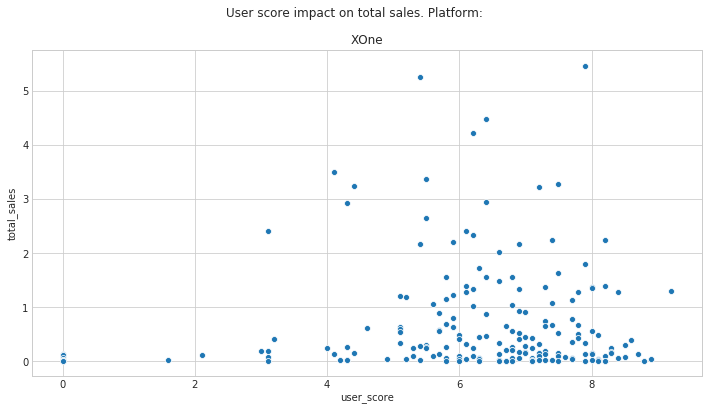

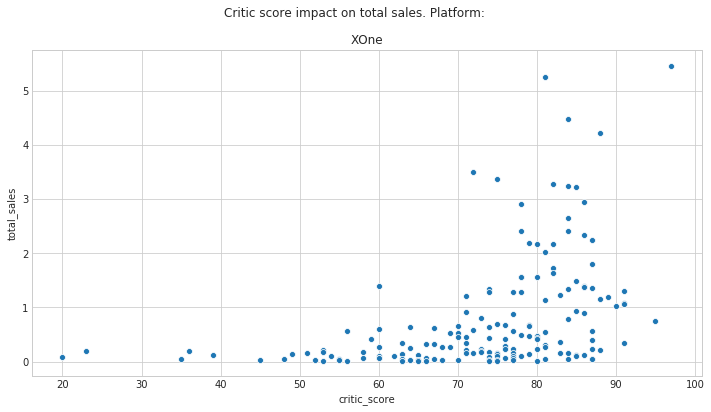

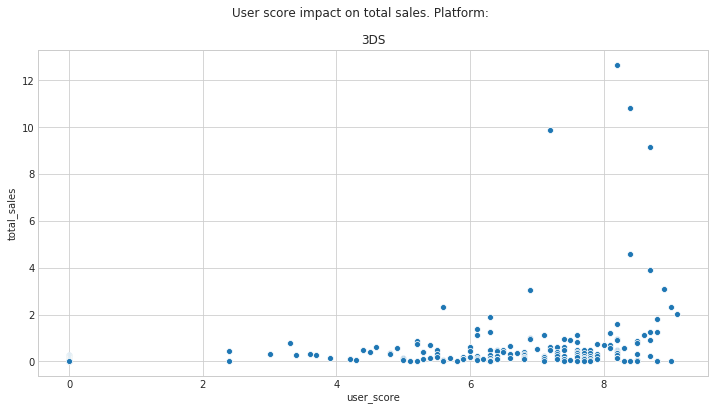

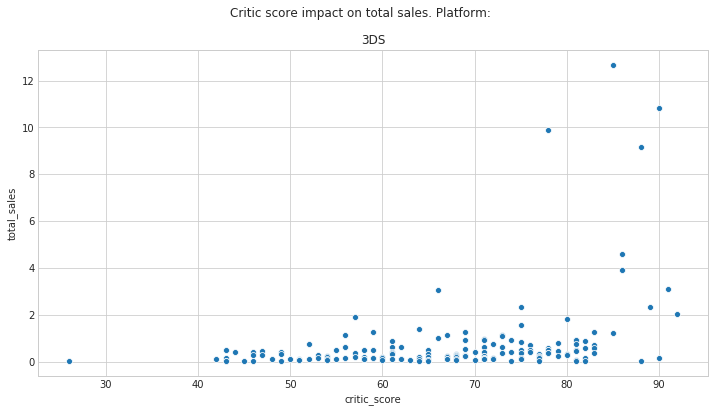

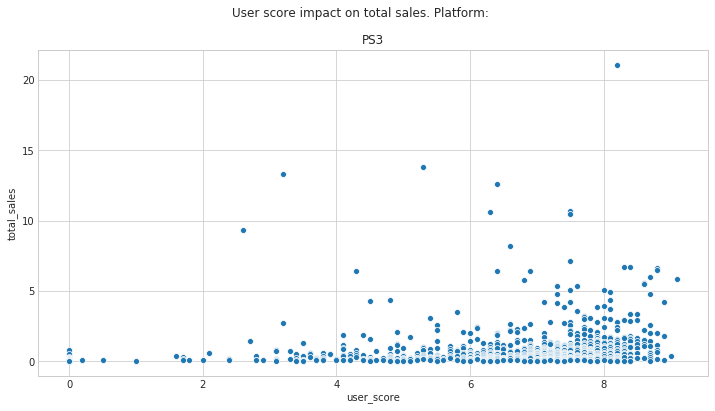

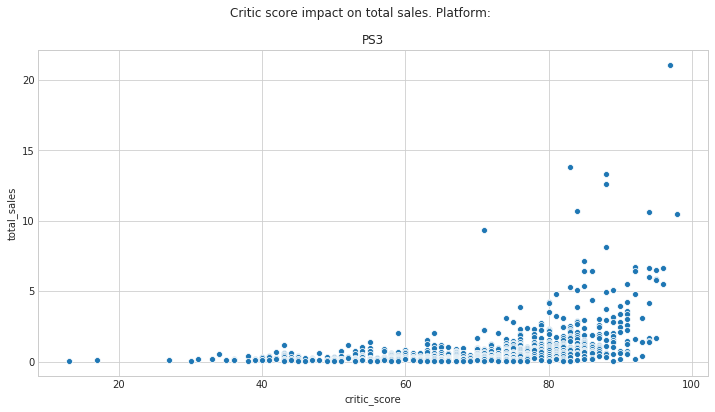

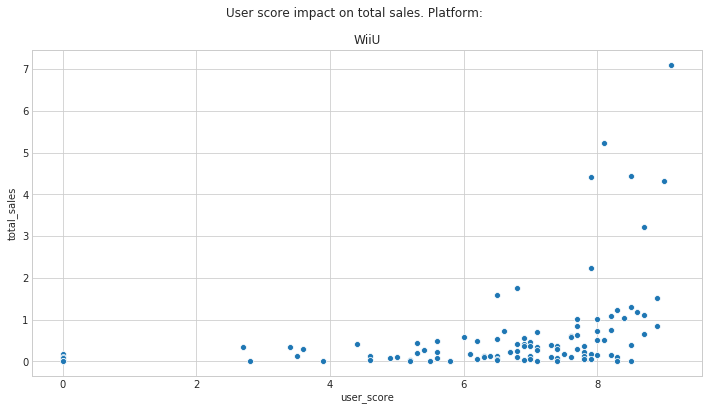

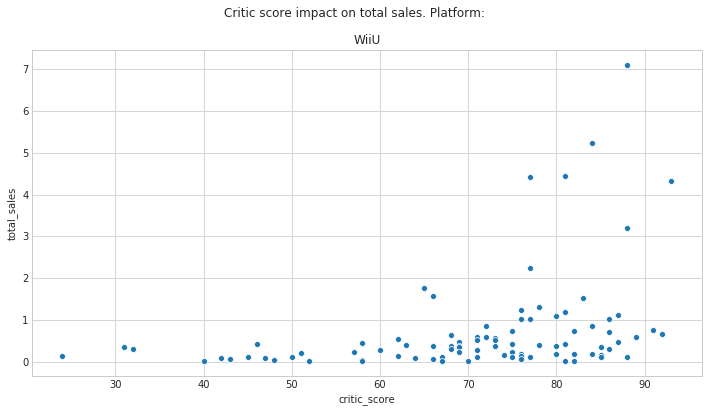

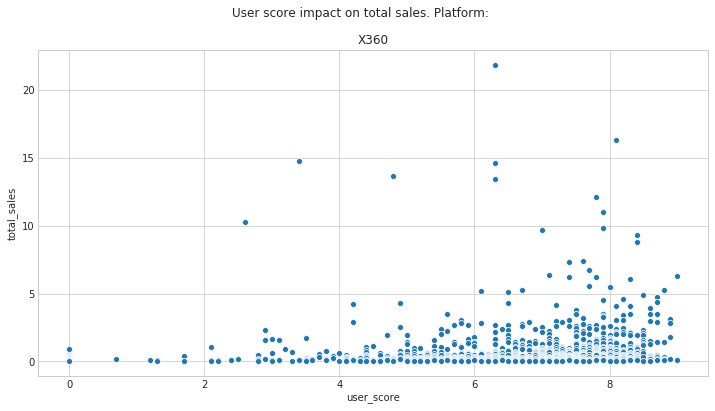

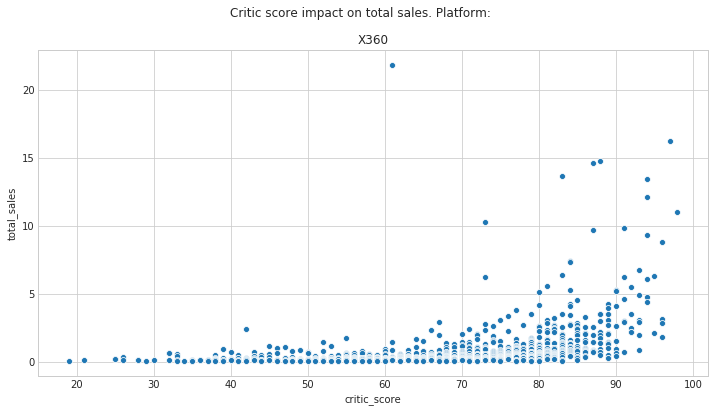

In [42]:
for x in top_platforms_list[1:6]:
    games_scatter(x)

We can see that trends that we defined based on PS4, in general, are the same for other platfroms, that was popular in last yaer. For some platforms, like 3DS and WiiU effect is more evident, but overall user score seems to not have effect on total sales, while critic score have effect, but pretty weak

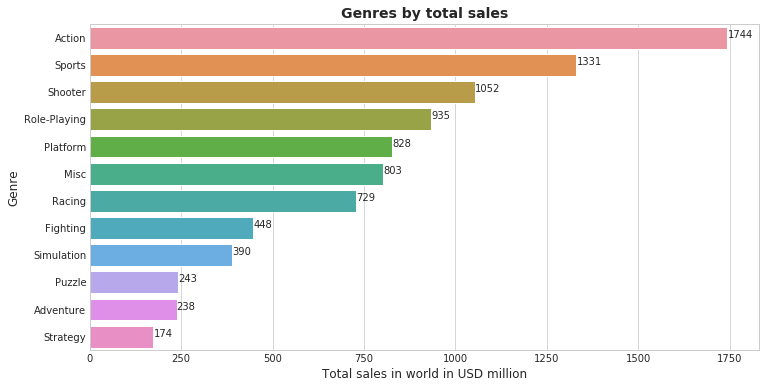

In [43]:
genres_slice = games[['genre','total_sales']].groupby('genre')['total_sales'].sum().reset_index().sort_values('total_sales', ascending=False)
plt.figure(figsize = (12,6))
fig = sns.barplot(x='total_sales',y='genre', data=genres_slice)
fig.set_title('Genres by total sales', weight='bold', fontsize='14')
fig.set_xlabel('Total sales in world in USD million', fontsize='12')
fig.set_ylabel('Genre', fontsize='12')
for index, value in enumerate(genres_slice['total_sales']):
    plt.text(value, index, str(round(value)))

In [44]:
genres_slice = genres_slice.sort_values(by='total_sales')
genres_slice['z_score'] = (genres_slice['total_sales'] - genres_slice['total_sales'].mean()) / genres_slice['total_sales'].std()
genres_slice['color'] = ['red' if x<0 else 'blue' for x in genres_slice['z_score']]

Text(0, 0.5, 'Genre')

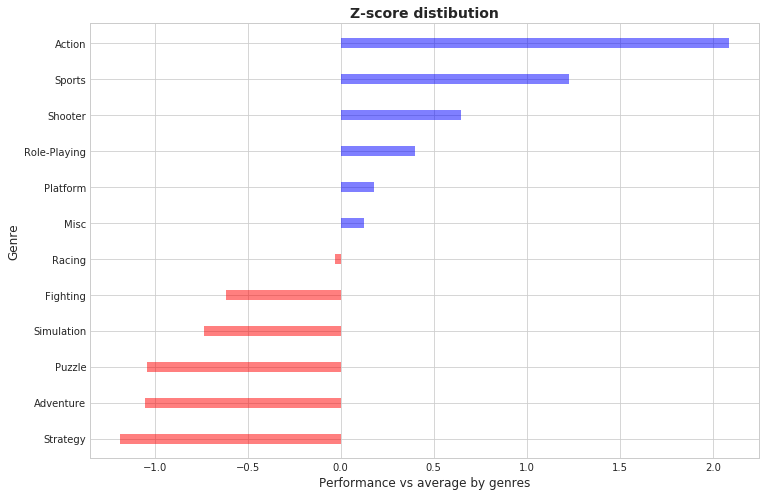

In [45]:
plt.figure(figsize = (12,8))
plt.hlines(y=genres_slice['genre'], xmin=0, xmax=genres_slice['z_score'], color = genres_slice['color'], alpha=0.5, linewidth=10) 
plt.title('Z-score distibution', weight='bold', fontsize='14')
plt.xlabel('Performance vs average by genres', fontsize='12')
plt.ylabel('Genre', fontsize='12')

- We can see that Action, Sports and Shooter are the most profitable genres. Role-playing and Platform are also performing higher than average for all genres.
- Strategies, Adventures and Puzzles are least profitable genres in terms of total sales. 
- This difference could be explained by the fact that genres with lower total sales are usually free-to-play games that are using different monetization strategy, while having no cost for installation. Also, leading genres are usually produced by big, well-known companies, such as EA Sports,Activision, Ubisoft, while less profitable genres are produced by small, independent companies which spend less time on producing game and failure is more acceptable for them

## Conclusion

1. 2008 was the most succsesful year, most amount of games was published this year
2. On average, it takes about 5 years for new platform to appear and then to go to 0 total sales afterwards
3. In terms of total sales over years leading ones are - PS2, X360, PS3, Wii, PS and DS
4. Average total sales varies significantly between different platforms
5. PS4 appears to be most promissing platfrom for 2017 it have increases in sale in previous years and also have quite high average total sales, compared to other platforms
6. Users score doesn't have significant impact on total sales 
7. Critic score have low impact on total sales
8. Action, Sports and Shooter are leading genres in terms of total sales, while Strategy, Puzzle and Adventures are least successful ones. This difference could be explained by different monetization strategies that company uses for different genres

# Part 4. Regional differences

### By platform

In [46]:
users_slice = games[['platform','na_sales','eu_sales','jp_sales']].groupby('platform').sum()

Text(0, 0.5, 'Sales, USD million ')

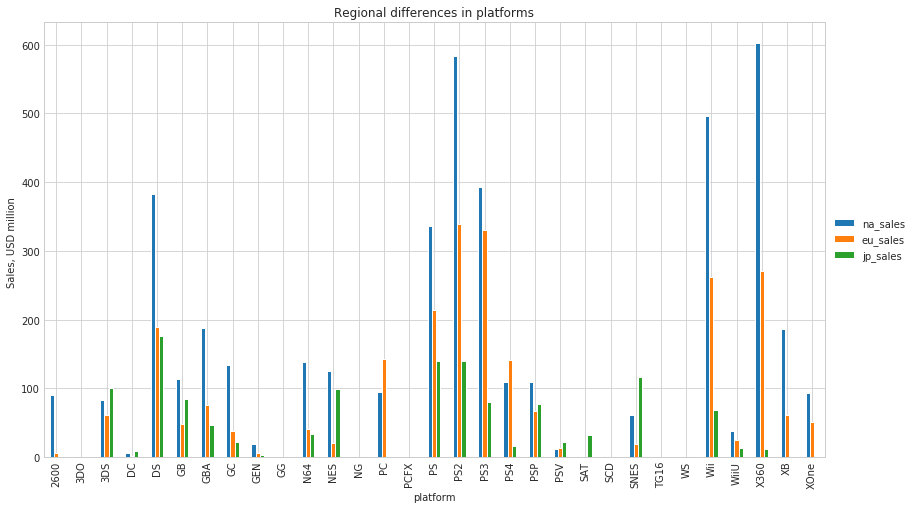

In [47]:
users_slice.plot(kind='bar', figsize = (14,8))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Regional differences in platforms')
plt.ylabel('Sales, USD million ')

In [48]:
users_slice[users_slice.index.isin(top_platforms_list)].sort_values('na_sales', ascending=False).head()

,na_sales,eu_sales,jp_sales
platform,,,
X360,602.47,270.76,12.43
PS3,393.49,330.29,80.19
PS4,108.74,141.09,15.96
XOne,93.12,51.59,0.34
3DS,83.49,61.48,100.67


In [49]:
users_slice[users_slice.index.isin(top_platforms_list)].sort_values('eu_sales', ascending=False).head()

,na_sales,eu_sales,jp_sales
platform,,,
PS3,393.49,330.29,80.19
X360,602.47,270.76,12.43
PS4,108.74,141.09,15.96
3DS,83.49,61.48,100.67
XOne,93.12,51.59,0.34


In [50]:
users_slice[users_slice.index.isin(top_platforms_list)].sort_values('jp_sales', ascending=False).head()

,na_sales,eu_sales,jp_sales
platform,,,
3DS,83.49,61.48,100.67
PS3,393.49,330.29,80.19
PS4,108.74,141.09,15.96
WiiU,38.10,25.13,13.01
X360,602.47,270.76,12.43


We can see, that there are obviously some regional differences in terms of sales of platform, that had hieghst sales in 2015. X360 is the most popular platform in North America, outperforming other popular platforms. In Europe PS3 is still leading platform, while in Japan 3DS have a lead in terms of popularity

### By genre

In [51]:
users_slice_2 = games[['genre','na_sales','eu_sales','jp_sales']].groupby('genre').sum()

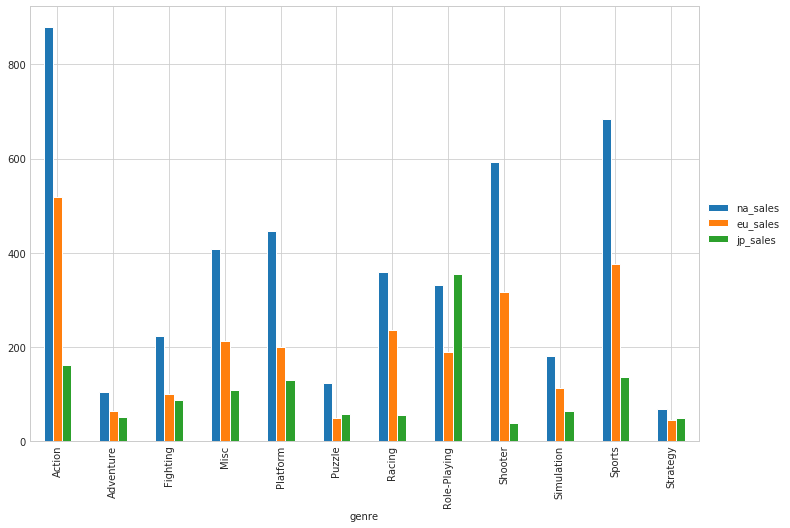

In [52]:
users_slice_2.plot(kind='bar', figsize = (12,8))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [53]:
users_slice_2.sort_values('na_sales', ascending=False).head()

,na_sales,eu_sales,jp_sales
genre,,,
Action,879.01,519.13,161.43
Sports,684.43,376.79,135.54
Shooter,592.24,317.34,38.76
Platform,445.50,200.35,130.83
Misc,407.27,212.74,108.11


In [54]:
users_slice_2.sort_values('eu_sales', ascending=False).head()

,na_sales,eu_sales,jp_sales
genre,,,
Action,879.01,519.13,161.43
Sports,684.43,376.79,135.54
Shooter,592.24,317.34,38.76
Racing,359.35,236.51,56.71
Misc,407.27,212.74,108.11


In [55]:
users_slice_2.sort_values('jp_sales', ascending=False).head()

,na_sales,eu_sales,jp_sales
genre,,,
Role-Playing,330.81,188.71,355.41
Action,879.01,519.13,161.43
Sports,684.43,376.79,135.54
Platform,445.50,200.35,130.83
Misc,407.27,212.74,108.11


There are differences in genre prefferences among users in diffrent regions, while North America and Europe have pretty evident leader, Action games, in Japan Role-Playing games taking first place. Another very importnant difference is Shooting genre, while in North America and Europe it takes 3rd place in terms of sales amount in Japan it takes last place in pair with Adventures. This could be explained by different attitude to guns in Western and Eastern cultures.

### By ESRB rating

In [56]:
users_slice_3 = games[['rating','na_sales','eu_sales','jp_sales']].groupby('rating').sum()

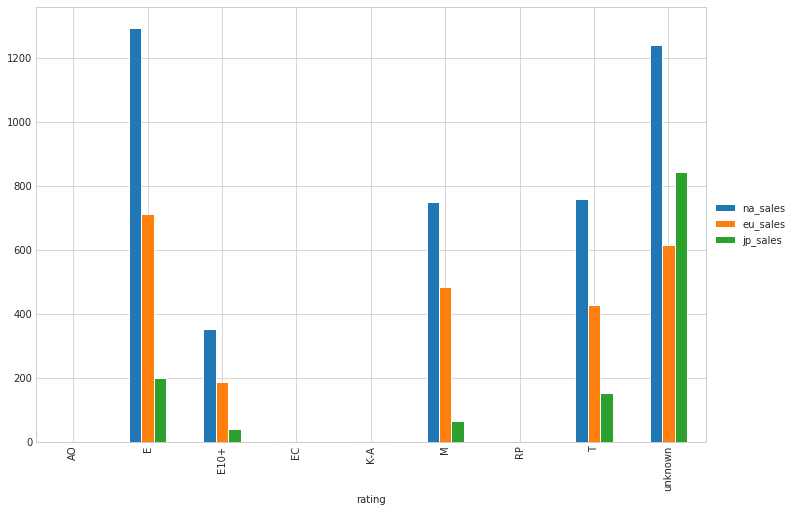

In [57]:
users_slice_3.plot(kind='bar', figsize = (12,8))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Overall, based on distribution we can assume that games with Unknown rating seems to be E rated, thus we can concluse that this is the most popular rating among all regions.
In general, we can't say that there are some differences in terms of rating between regions. 

## Conclusion

There are significant difference in users profile between different regions:
 - In North America most popular platform is still X360, while in Europe PS3 is the leading one. In Japan on countrary 3DS taking leading place
 - Actions is the most popular genre in North America and Europe, while Role-Playing is leading one in Japan. Shooting genre is least popular in Japan, while been one of the most popular in other regions
 - In general, we can't say that there are some differences in terms of rating between regions. 

# Part 5. Hypothesis testing

We going to use alpha level on 0.05, because we don't need more precise results, but also we don't want to have more mistakes

In [58]:
a = 0.05

### Hypothesis testing 1. 

H0 - Average user ratings of the Xbox One and PC platforms are the same <p>
H1 - There are significant difference in average users rating of the Xbox One and PC platforms 
Since we need to compare means of two populations we going to use t-test and due to rather similar variance and assumption that those samples are pretty similar, since both of them are scores that, in some cases, same gamers giving to similar games on diffent platform. Thus we going to use paired t-test.

In [59]:
print(games['user_score'][games['platform'] == 'XOne'].std())
print(games['user_score'][games['platform'] == 'PC'].std())

2.0237167835531094
2.2382222019793403


In [60]:
sample1 = games[games['user_score'].notna()]['user_score'][games['platform'] == 'XOne']
sample2 = games[games['user_score'].notna()]['user_score'][games['platform'] == 'PC']
levene = st.levene(sample1, sample2, center='median')
if levene.pvalue < a:
    print('Sample groups do not have equal variance')
else:
    print("Sample groups have equal variance")

Sample groups have equal variance


In [61]:
result = st.ttest_ind(games['user_score'][games['platform'] == 'XOne'],games['user_score'][games['platform'] == 'PC'])

if result.pvalue < a:
    print('Reject the H0 hypothesis')
else:
    print("Can't reject H0 hypothesis")

Can't reject H0 hypothesis


In [62]:
print(games['user_score'][games['platform'] == 'XOne'].mean())
print(games['user_score'][games['platform'] == 'PC'].mean())

6.149740932642487
6.63992673992674


### Conclusion

Based on results of statistical test, we can't reject H0 hypothesis, which means that there is no significant difference between average users score of Xbox One platform and PC platform games

### Hypothesis testing 2. 

H0 - Average user ratings for Action and Sports genres are the same <p>
H1 - Average user ratings for the Action and Sports genres are different <p>
Since we have similar samples that where taken from population with similar parameters, we going to use paired t-test and significance level 95%

In [63]:
print(games['user_score'][games['genre'] == 'Action'].std())
print(games['user_score'][games['genre'] == 'Sports'].std())

2.953663965016746
3.391161003693001


In [64]:
sample1 = games['user_score'][games['genre'] == 'Action']
sample2 = games['user_score'][games['genre'] == 'Sports']
levene = st.levene(sample1, sample2, center='median')
if levene.pvalue < a:
    print('Sample groups do not have equal variance')
else:
    print("Sample groups have equal variance")

Sample groups have equal variance


In [65]:
result = st.ttest_ind(games['user_score'][games['genre'] == 'Action'],games['user_score'][games['genre'] == 'Action'])

if result.pvalue < a:
    print('Reject the H0 hypothesis')
else:
    print("Can't reject H0 hypothesis")

Can't reject H0 hypothesis


In [66]:
print(games['user_score'][games['genre'] == 'Action'].mean())
print(games['user_score'][games['genre'] == 'Sports'].mean())

5.851722574796011
5.064775725593668


### Conclusion

Based on results of t-test we can conclude that there is not enough evidence to reject H0 hypothesis, so we can say that there is no significant difference between average user ratings for Action and Sports genres

# Overall conclusion

Overall, we can say that there is general trend that amount of published games overall goes down. Sales of most successful platforms like PS2, PS3, DS, PS, Wii also goes down. Based on this, its important to emphasize on PS4 platform, since it seems to be most promising one for the 2017, due to several reasons:
 - It performs better that average by total sales and didn't had unsuccessful years yet
 - Amount of games published for this platform goes up
 - It appeared several years ago, which means that its close to its peak. On average it takes around 2,5 year for platform to reach its peak and another 2,5 years to dissapear from market <p>
    

In order to choose game that we going to promote we need to pay attention to critics score, since it have impact on total sales. In general, we can say that the higher critic score higher going to be sales. Also, critics score usually available before game is published, so we can know them and then decide to promote game or not. <p>
In terms of genres, we need to choose Action, Sports or Shooter, since those are top 3 selling genres. <p>
There are evident regional preferences in terms of platforms and genres:
- X360 is the most popular platform in North America, outperforming other popular platforms. In Europe PS3 is still leading platform, while in Japan 3DS have a lead in terms of popularity
- Due to cultural differences Japan and North America & Europe have different popular genre, while in NA and Europe its Action and Shooter in Japan its Role-Playing
- There is no evident differences in terms of ratings between regions
<p>
   
    
We tested two hypothesis and can say that:
- Average rating of PC and XBoxOne games are the same
- Average user ratings of Action and Sports games are the same